In [219]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
import json
import matplotlib.pyplot as plt

import datetime
from gensim import corpora
from gensim import models
from itertools import chain
from nltk.stem.wordnet import WordNetLemmatizer
from pyLDAvis import gensim as gs
from pymongo import MongoClient

if 'outputs' not in os.listdir():
    os.mkdir("outputs")

In [4]:
# taken from http://stackoverflow.com/questions/16249736/how-to-import-data-from-mongodb-to-pandas
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df
    

def pre_process_text(document):
    '''
    input = document, a string
    output = A list of tokens for analysis in gensim
    '''
    
    # To lowercase
    document = document.lower()
    
    # Remove html
    document = strip_fluff(document)
    
    # Tokenize and lemmatize
    sents = sent_detector.tokenize(document)
    tokens = []
    for sent in sents:
        tokens += tokenizor.tokenize(sent)
    tokens = [x for x in tokens if x not in(string.punctuation)]
    tokens_lemmatized = [lmtzr.lemmatize(token) for token in tokens]

    # Get position
    tagset = None
    tokens_lab = tagger.tag(tokens_lemmatized)
    
    # Focus on nouns and remove stopwords
    tokens_selected = [tok[0] for tok in tokens_lab if tok[0] not in words_to_remove and tok[1]=="NN"]
    
    return tokens_selected

def strip_fluff(doc):
    s = strip_html(doc)
    s = strip_url(s)
    s = strip_newline(s)
    s = strip_nbsp(s)
    return s

def strip_html(doc):
    p = re.compile(r'<.*?>')
    return p.sub(' ', doc)

def strip_url(doc):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', doc)

def strip_newline(doc):
    return doc.replace('\n', ' ')

def strip_nbsp(doc):
    return doc.replace('&nbsp;', ' ')

def strip_html_entity(doc):
    return doc.replace('&amp;')

In [116]:

def Extract_Date(unix_epoch,period="Year"):
    '''
    #Input = a dict containing a unix epoch int
    #Returns a date object (date or year depending on parameter)
    '''
    #It works by extracting the date from the epoch, and then getting the year
    #NB use if else to deal with variation in types of input
    
    if type(unix_epoch)==dict:
        my_int = int(unix_epoch['$numberLong'])
        date = datetime.date.fromtimestamp(my_int/1000)
        
    elif type(unix_epoch)==int:
        date = datetime.date.fromtimestamp(unix_epoch/1000)
    
    elif np.isnan(unix_epoch) == True:
        date = np.nan
            
    if period=="Year":
    
        output = date.year if type(date)==datetime.date else np.nan
    
    else:
        output = date
    
    return(output)

def Extract_Group_Data(group):
    '''
    This function extracts relevant data from a json object
    input: a dict with information about a Meetup group
    output: a dict with relevant information we
        can readily turn into a DF.
    including a field with user ids that we will later match vs. the user DF.
    '''
    
    #We have a set of fields in the dict that are "easy to extract"
    simple_vars = ['id','member_ids','city','name','country','lon','lat','created']
    
    #In some cases not all variables are available for a group
    #We need to create those variables and give them missing values.
    #We do this by comparing the set of names (keys) in the object and 
        #the "simple vars"
    vars_in_object = group.keys()
    
    if len(set(simple_vars)-set(vars_in_object))>0:
        missing_vars=set(simple_vars)-set(vars_in_object)
        for i in missing_vars:
            group[i] = np.nan
                
    #Topics is a dict inside the group dict
    topics = [item['urlkey'] for item in group['topics']]
    #We convert it into a single string ('document') for topic modelling later
        #But return a nan if the length of topics is 0 (no topics in this user)
    group['topic_string'] = ', '.join(topics) if len(topics)>0 else np.nan

    #Event dates are also a dict inside a dict.
    #We use the Extract_Year function
    event_dates = [Extract_Date(item['updated']) for item in group['events_in_window']]
    #We want the latest year when there was an event for the group
    group['latest_event_year'] = max(event_dates) if len(event_dates)>0 else np.nan
    
    #Transform unix epochs into dates using Extract_Date variable
    group['created_year'] = Extract_Date(group['created'])
    group['created_date'] = Extract_Date(group['created'],period="All")
    
    
    #Output variables 
    out_vars = ['id','name','member_ids','city','country','lon','lat','created_year',
               'latest_event_year','created_date','topic_string']
    
    group_selected = {key:value for key,value in group.items() if key in out_vars}
    return(group_selected)


def Read_Parse_Group_Data(path_to_file):
    '''
    Input: path to a json file we want to process for analysis
    Output: A dataframe with relevant fields for EDA
    '''
    records = [json.loads(line.decode()) for line in open(path_to_file, 'rb')]
    
    #Create list
    group_list = [Extract_Group_Data(group) for group in records]

    #Create category name to add as a field to the data frame
    data_type = path_to_file.split(".")[0]
    
    #Create DF
    group_df = pd.DataFrame(group_list)
    group_df['data_type'] = data_type
        
    return(group_df)

def keyword_extraction_via_lda(keyword_corpus,topic_number=25):
    '''
    Input: A list where every element is a list of keywords for the group, and the number of topics to use
        #with the topic extraction.
    Returns: a list with two elements: the keyword mix per topic and the topic mix per element in row (group)
    
    '''
    
    # Create dictionary from list above
    term_dict = corpora.Dictionary(keyword_corpus)

    # Create bag of words representation
    corpus = [term_dict.doc2bow(gr) for gr in keyword_corpus]

    # Initialise TF-IDF model
    tfidf_model = models.TfidfModel(corpus)

    # Fit the TF-IDF model
    tfidf_fit = tfidf_model[corpus]
    
    #Initialise lda model
    lda = models.LdaMulticore(corpus,
                              id2word=term_dict,
                              num_topics=topic_number,
                              passes=100,
                              iterations=300,
                              workers=3)
    
    #Create topic distribution
    doc_topics = lda[tfidf_fit]
    
    
    #Return outputs
    return([lda.show_topics(num_topics=topic_number),doc_topics])


def label_topic_df(topic_mix,df_to_label,topic_label_lookup):
    '''
    Input: A topic mix, a df_to_label (with the topics), a topic_label_lookup (to label topics) and a
    geo_area to generate topic distributions
    Returns: A df with groups labelled by top topic
    
    '''
    
    #Topic mix df
    topic_dist = pd.DataFrame([dict(tup) for tup in topic_mix]).fillna(value=0)
    
    #Allocate row to topic with max probability
    topics_allocated = pd.DataFrame(data={'top_topic': topic_dist.idxmax(axis=1)})
    
    #Allocate group to topic
    df_to_label['topic_names'] = topics_allocated.apply (lambda row: topic_label_lookup[row['top_topic']], axis=1)
    
    return(df_to_label)
    #Now we need to geocode these.

### Create stop words and read the data from source

In [5]:
# Read in place names from a file, line by line, as a list
with open(os.path.dirname(os.path.dirname(os.getcwd())) + '/data/towns_and_cities_2015.txt') as fp:
    place_names = [line.rstrip('\n') for line in fp]

# Load lemmatizer
lmtzr = WordNetLemmatizer()

### Analyze Business Groups First

In [44]:
# Business group DataFrame
#business_meetups = read_mongo('meetup', 'groups')

tech_meetups= Read_Parse_Group_Data("../../data/meetup/tech_groups.json")
business_meetups = Read_Parse_Group_Data("../../data/meetup/bus_groups.json")

In [53]:
# List of lists containing group topics (NB changed because this is a different input)
#business_group_topics = [[y.split(", ") for y in x] for x in business_meetups['topic_string']]
business_group_topics = [x.split(", ") for x in business_meetups['topic_string']]

#business_group_topics = [[y.split(", ") for y in x] for x in business_meetups['topic_string']]
tech_group_topics = [x.split(", ") for x in tech_meetups['topic_string']]

In [102]:
#Extract topics
np.random.seed(123)
biz_outs = keyword_extraction_via_lda(business_group_topics,25)
tech_outs = keyword_extraction_via_lda(tech_group_topics,25)

In [107]:
# Lookup topic names
busines_topic_lookup = {
    0: 'startup',
    1: 'entrepreneurship_mixed',
    2: 'women_professionals',
    3: 'contractors',
    4: 'trading',
    5: 'business_support',
    6: 'black_professionals',
    7: 'finance',
    8: 'entrepreneurship',
    9: 'freelancers',
    10: 'hr',
    11: 'law',
    12: 'business_networking',
    13: 'e_commerce',
    14: 'branding',
    15: 'investment',
    16: 'marketing',
    17: 'fashion_brands_mixed',
    18: 'business_networking_2',
    19: 'real_state',
    20: 'healthcare',
    21: 'presentation_skills',
    22: 'personal_development',
    23: 'finance_2',
    24: 'self_improvement'
}

tech_topic_lookup = {
    0: 'creative_mixed',
    1: 'windows',
    2: 'cloud',
    3: 'big_data',
    4: 'civic_tech',
    5: 'wordpress',
    6: 'women_tech',
    7: 'devops',
    8: 'saas',
    9: 'vr_ar',
    10: 'content',
    11: 'new_tech',
    12: 'games',
    13: 'web_development',
    14: 'makers_hackers',
    15: 'smartphone',
    16: 'project_management',
    17: 'programming',
    18: 'crypto',
    19: 'google',
    20: 'startups_tech',
    21: 'digital_marketing',
    22: 'ux',
    23: 'cms',
    24: 'fintech'
}

tech_topic_dict = {
    0: 'Web Development',
    1: 'Tech Entrepreneurs',
    2: 'Data Analytics',
    3: 'Agile Workflows',
    4: 'Design',
    5: 'Cloud Computing',
    6: 'Technology Professionals',
    7: 'Game Development',
    8: 'Internet of Things',
    9: 'NoSQL',
    10: 'Makers',
    11: 'WordPress',
    12: 'DevOps',
    13: 'Virtual Reality',
    14: 'Mobile App Development',
    15: 'Functional Programming',
    16: 'Cryptographic Currencies',
    17: 'User Experience',
    18: 'Python',
    19: 'Security',
    20: 'Distributed Computing',
    21: 'SEO',
    22: 'Scrum',
    23: 'Hackathon',
    24: 'Open Data'
}

In [193]:
tech_df = label_topic_df(tech_outs[1],tech_meetups,tech_topic_lookup)
ent_df = label_topic_df(biz_outs[1],business_meetups,busines_topic_lookup)

groups_labelled_df = pd.concat([tech_df,ent_df]).reset_index(drop=True)

In [186]:
#groups_labelled_df = groups_labelled_df[[x=="London" for x in groups_labelled_df.city]]

In [194]:
#Now we need to geo_label this (copied and pasted from previous)
import geopandas
from geopandas import tools
from shapely.geometry import Point

def check_lat_lon(row):
    """Returns false if the row has null lat or lng values"""
    return True if not pd.isnull(row.lat) or not pd.isnull(row.lng) else False

groups_labelled_df["geometry"] = groups_labelled_df.apply(lambda row: Point(row["lon"], row["lat"]) if check_lat_lon(row) else None, axis=1)
groups_labelled_df.drop(['lat', 'lon'], axis=1, inplace=True)

# Now we need a GeoDataFrame and to tell
# Geopandas what the coordinate system used is
groups_labelled_df = geopandas.GeoDataFrame(groups_labelled_df, geometry="geometry")
groups_labelled_df.crs = {"init": "epsg:4326"}

# Now load the topojson to a seperate GeoDataFrame object
lads = geopandas.GeoDataFrame.from_file("../industry/data/topo_lad.json")
lads.crs = {"init": "epsg:4326"}

# Perform the spatial join
groups_labelled_df = tools.sjoin(lads, groups_labelled_df, how="left")
groups_labelled_df.rename(columns={'id_left': 'lad', 'id_right': 'id'}, inplace=True)

# LUT Output
groups_labelled_df[['name', 'id', 'lad']].to_pickle("../industry/intermediate_outputs/lad_meetup.p")
groups_labelled_df.to_csv("../industry/intermediate_outputs/meetups_df.csv", index=False)


In [234]:
#Area topic distribution
area_topic_distr = pd.crosstab(groups_labelled_df.LAD13NM,groups_labelled_df.topic_names).reset_index(drop=False)

In [252]:
#Calculate LQs. What do we normalise by: Business populations?
city_biz_counts = pd.read_csv("../industry/intermediate_outputs/city_biz_counts.csv")
city_biz_counts.rename(columns={"local authority: district / unitary (prior to April 2015)":'lad',
                               '0':'biz_counts'},inplace=True)

#Produce LQ
#Merge
lad_meetup_for_lq = pd.merge(area_topic_distr,
                         city_biz_counts,
                         left_on='LAD13NM',right_on='lad')
#Lose the lad variable
lad_meetup_for_lq.drop('lad',inplace=True,axis=1)

#Generate LQs
#Local shares 1 (based on biz counts in the city)
local_shares_1 = lad_meetup_for_lq.biz_counts/lad_meetup_for_lq.biz_counts.sum()

#Local shares 2 (based on colsums in the matrix, removing the last column with business counts)
local_shares_2 = lad_meetup_for_lq.ix[:,1:-1].sum(axis=1)/np.sum(lad_meetup_for_lq.ix[:,1:-1].sum(axis=1))


lad_meetup_lq = lad_meetup_for_lq.ix[:,1:-1].apply(lambda x: (x/x.sum()/local_shares_1))
lad_meetup_lq.index = lad_meetup_for_lq['LAD13NM']
lad_meetup_lq.to_csv("outputs/meetup_lqs")


/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


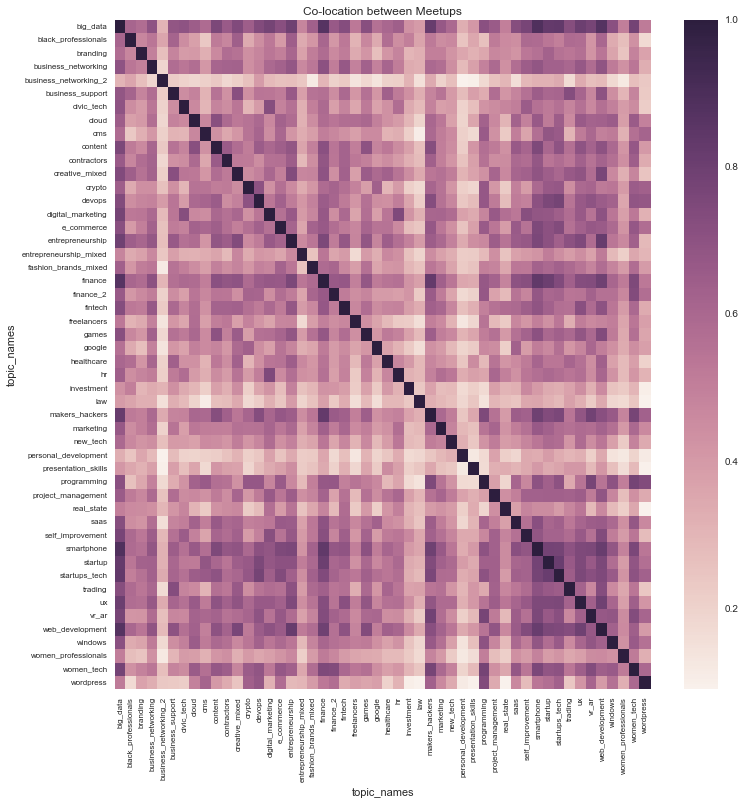

In [253]:
plot = plt.figure(figsize=(12,12))
plot = sns.heatmap(lad_meetup_lq.corr())
plot.tick_params(labelsize=8)
plt.title("Co-location between Meetups")

In [254]:
industry_clusters = pd.read_csv("../industry/intermediate_outputs/industry_clusters.csv")
#Merge industry and research clusters

all_activity = pd.merge(industry_clusters,lad_meetup_lq.reset_index(drop=False),
                       left_on='lad_name',
                       right_on='LAD13NM')

all_activity_corr_1 = all_activity.corr()

all_activity_corr = all_activity_corr_1.ix[industry_clusters.columns[1:],lad_meetup_lq.columns]


/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


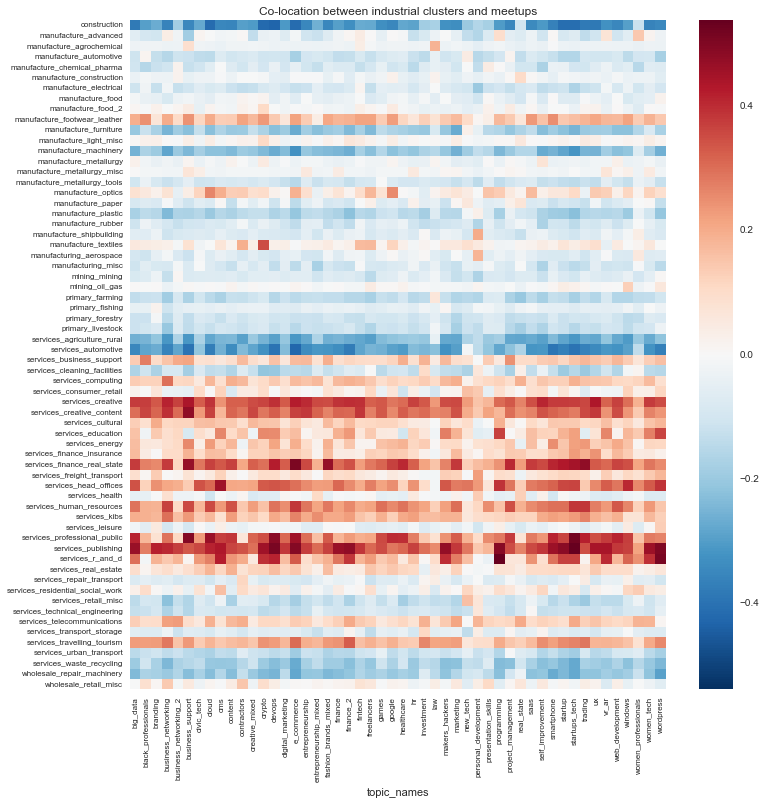

In [255]:
#Plot relations
plot = plt.figure(figsize=(12,12))
plot = sns.heatmap(all_activity_corr)
plot.tick_params(labelsize=8)
plt.title("Co-location between industrial clusters and meetups")

/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


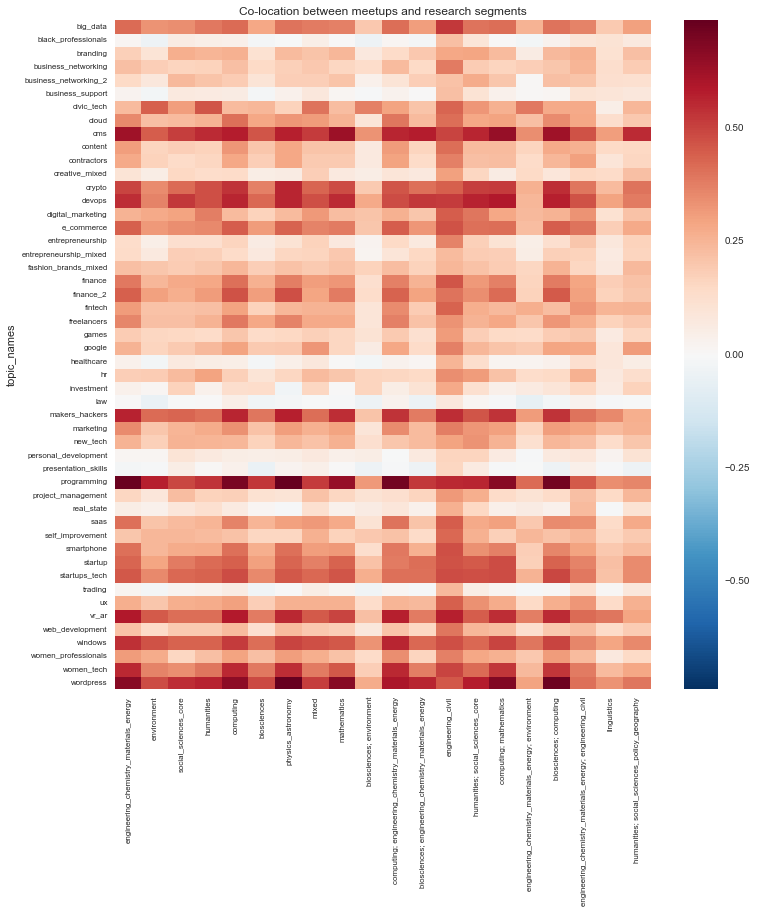

In [256]:
gtr_clusters = pd.read_csv("../gtr/outputs/gtr_subjects.csv")

other_pairs = pd.merge(gtr_clusters,lad_meetup_lq.reset_index(drop=False),
                       left_on='LAD13NM',
                       right_on='LAD13NM')

other_activity_corr_1 = other_pairs.corr()

other_activity_corr = other_activity_corr_1.ix[lad_meetup_lq.columns,gtr_clusters.columns[1:]]

#Plot relations
plot = plt.figure(figsize=(12,12))
plot = sns.heatmap(other_activity_corr)
plot.tick_params(labelsize=8)
plt.title("Co-location between meetups and research segments")
